In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import nltk
import os
import pickle
from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import string
import re, itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

SQL CODE:

SELECT *
FROM Posts
WHERE
    PostTypeId = 1 AND
    Score >=0 AND
    CreationDate >= '20180101' AND
    Tags <> 0
    

In [2]:
#dataloading

#To copy paste in the list of parameters below to limit the dataset size
#postsdf = pd.read_csv('posts with tags.csv', nrows = 50, index_col=0, parse_dates=['CreationDate', 'DeletionDate', 'LastEditDate', 'LastActivityDate', 'ClosedDate'])

#complete loading
postsdf = pd.read_csv('posts with tags.csv', index_col=0, parse_dates=['CreationDate', 'DeletionDate', 'LastEditDate', 'LastActivityDate', 'ClosedDate'])
postsdf.head()

,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,...,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
Id,,,,,,,,,,,,,,,,,,,,,
48046688,1,NaN,NaN,2018-01-01 01:43:05,NaT,0,32,<p>Hi I was trying to install a python package...,9159552.0,NaN,...,NaN,2018-01-01 02:50:41,2018-01-01 02:50:41,tried to install a pythonn package but encount...,<python><gcc>,0,0,NaN,NaT,NaN
48046690,1,NaN,NaN,2018-01-01 01:44:46,NaT,0,39,<p>I am trying to make a chrome extension that...,9159517.0,NaN,...,NaN,2018-01-01 16:59:50,2018-01-01 16:59:50,Update chrome extension popup text,<javascript><html><google-chrome-extension>,0,3,NaN,NaT,NaN
48046378,1,NaN,NaN,2018-01-01 00:00:29,NaT,0,39,<p>Calling a <em>dll</em> from Python using <e...,8276973.0,NaN,...,NaN,2018-01-01 03:16:54,2018-01-03 08:21:23,Python ctypes: how to pass ctypes array to DLL?,<python><ctypes>,2,0,NaN,NaT,NaN
48046379,1,NaN,NaN,2018-01-01 00:00:32,NaT,0,390,<p>I have a Django app with which users can cr...,1745384.0,NaN,...,NaN,2018-01-01 03:18:33,2018-01-11 23:14:31,nginx gunicorn 502 bad gateway: upstream prema...,<python><django><nginx>,1,0,1.0,NaT,NaN
48046382,1,NaN,NaN,2018-01-01 00:00:52,NaT,0,44,<p>I'm trying to implement hittest that is use...,8794406.0,NaN,...,NaN,NaT,2018-01-01 00:00:52,Implementing hit test,<c++><opencv><3d><computer-vision><arkit>,0,0,NaN,NaT,NaN


In [3]:
#List of columns availabale
postsdf.columns.values

array(['PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate'], dtype=object)

In [4]:
#Tags parsing on dataset
postsdf['PTags'] = postsdf['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
postsdf['LenTags'] = postsdf['PTags'].apply(lambda x: len(x))
postsdf[['PTags', 'Tags', 'LenTags']].sort_values('LenTags', ascending = False).head()

,PTags,Tags,LenTags
Id,,,
48094601,"[list, function, sharepoint-2010, calculated-c...",<list><function><sharepoint-2010><calculated-c...,5
48180277,"[java, spring, spring-boot, cron, spring-sched...",<java><spring><spring-boot><cron><spring-sched...,5
48079684,"[docker, docker-compose, docker-swarm, docker-...",<docker><docker-compose><docker-swarm><docker-...,5
48126497,"[ios, swift, video, rotation, avfoundation]",<ios><swift><video><rotation><avfoundation>,5
48080749,"[c++, boost, number-formatting, standard-libra...",<c++><boost><number-formatting><standard-libra...,5


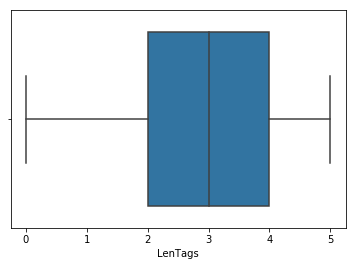

In [5]:
#How many tags per posts
#postsdf['LenTags'].plot(kind='box')
sns.boxplot(postsdf['LenTags'])
#plt.show()

In [6]:
#What are the tags in the HTML body ?
postsdf['TagsSet'] = postsdf['Body'].apply(lambda x: set([tag.name for tag in BeautifulSoup(x, 'lxml').find_all()]))
postsdf['TagsSetLen'] = postsdf['TagsSet'].apply(lambda x: len(x))
print(postsdf['TagsSetLen'].describe())
#print(postsdf['TagsSet'].str.join(sep='*').str.get_dummies(sep='*').describe())
postsdf[['TagsSet', 'Body', 'TagsSetLen']].sort_values('TagsSetLen', ascending = False).head(20)

count    50000.000000
mean         5.413480
std          1.407265
min          3.000000
25%          5.000000
50%          5.000000
75%          6.000000
max         15.000000
Name: TagsSetLen, dtype: float64


,TagsSet,Body,TagsSetLen
Id,,,
48176897,"{br, li, h1, code, p, ol, hr, h2, html, h3, a,...","<p>I am pretty new to knockoutJS, have complet...",15
48059195,"{ul, li, code, p, ol, hr, div, html, em, a, st...","<p>I have been <a href=""https://github.com/kau...",14
48118901,"{ul, li, code, h1, p, hr, html, em, h3, a, str...",<p>I have two services running on Azure :</p>\...,14
48171199,"{ul, li, code, p, ol, h2, html, em, h3, a, str...",<p>I'm build the backend for a web app. When a...,14
48173979,"{ul, li, code, body, p, ol, hr, div, html, a, ...",<h2>Find length of line 300* slower</h2>\n\n<p...,14
48116359,"{br, ul, li, code, p, ol, hr, html, em, h3, a,...",<p>Although it's much more complex than I'm ab...,14
48080865,"{br, li, code, p, ol, h2, html, em, a, strong,...",<p>I try to analyze one module of a multi modu...,13
48144185,"{li, code, p, ol, hr, h2, html, em, a, strong,...",<p>I have the following custom view <code>Dial...,13
48176556,"{br, ul, li, code, p, ol, html, em, a, strong,...",<p><strong>Context/Background</strong>: I have...,13


https://www.w3schools.com/TAGs/

In [7]:
#List of all the HTML tags in the dataset
postsdf['TagsSet'].str.join(sep='*').str.get_dummies(sep='*').columns.values

array(['a', 'b', 'blockquote', 'body', 'br', 'code', 'dd', 'div', 'dl',
       'dt', 'em', 'h1', 'h2', 'h3', 'hr', 'html', 'i', 'img', 'kbd', 'li',
       'ol', 'p', 'pre', 's', 'strike', 'strong', 'sub', 'sup', 'ul'], dtype=object)

In [8]:
#Title  - general information
postsdf['LenTitle'] = postsdf['Title'].apply(lambda x:len(x.split(' ')))
postsdf[['LenTitle', 'Title']].sort_values('LenTitle', ascending = False).head()

,LenTitle,Title
Id,,
48071275,32,TV channel in C# and I'm using Vlc API. When t...
48158843,30,If I have a function that prints as many times...
48109943,30,Snakemake only re-runs jobs if one of the inpu...
48159052,29,I'm trying to write a script to search a folde...
48050389,29,How do I build apk for android API 21 using Io...


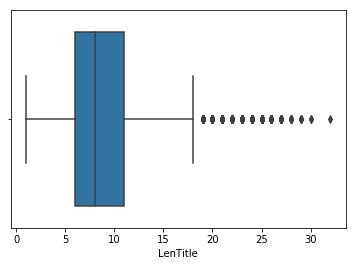

In [9]:
#How many words in the title ?
sns.boxplot(postsdf["LenTitle"])

In [10]:
#Conversion of tags into a list
postsdf['PTags'] = postsdf['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
postsdf[['PTags', 'Tags']].head()

,PTags,Tags
Id,,
48046688,"[python, gcc]",<python><gcc>
48046690,"[javascript, html, google-chrome-extension]",<javascript><html><google-chrome-extension>
48046378,"[python, ctypes]",<python><ctypes>
48046379,"[python, django, nginx]",<python><django><nginx>
48046382,"[c++, opencv, computer-vision, arkit]",<c++><opencv><3d><computer-vision><arkit>


In [11]:
#Prototype
#General parsing test

sampleline = 48048147

textsample = postsdf['Body'].loc[sampleline]
titlesample = postsdf['Title'].loc[sampleline]
tagssample = postsdf['Tags'].loc[sampleline]
soupBody = BeautifulSoup(textsample, 'lxml')
soupTags = BeautifulSoup(tagssample, 'html.parser')

In [12]:
#Tags parsing
'|'.join(set([tag.name for tag in soupTags.find_all()]))

'c++|file|ifstream|byte-order-mark|file-io'

In [13]:
#Raw version Body
print(BeautifulSoup(postsdf['Body'].loc[sampleline], 'lxml').prettify())

<html>
 <body>
  <p>
   I have a .txt file called "1.txt" that I want to read in.  Since the file starts with 8 BOM characters, if I do the following:
  </p>
  <pre><code>ifstream fin("1.txt");

string temp = "";

char c = fin.get();

    while (!fin.eof())
    {
        if (c &gt;= ' ' &amp;&amp; c &lt;= 'z')
        {
            temp += c;
        }

        c = fin.get();
    }

    cout &lt;&lt; temp;
</code></pre>
  <p>
   This will print nothing, because of something the BOM is doing.
  </p>
  <p>
   So, I decided to use the fin.ignore() function, in order to ignore the beginning BOM characters of the file.  However, still nothing is being printed.  Here is my complete program:
  </p>
  <pre><code>#include &lt;iostream&gt;
#include &lt;fstream&gt;
#include &lt;string&gt;
#include &lt;istream&gt;

using namespace std;

int main()
{
ifstream fin("1.txt");

if (fin.fail())
{
    cout &lt;&lt; "Fail\n";
}

else
{
    string temp = ""; // Will hold 1.txt's contents.

    fin.ignore(1

In [14]:
#Code parsing
for text in soupBody.find_all('code'):
    print(text.text)

ifstream fin("1.txt");

string temp = "";

char c = fin.get();

    while (!fin.eof())
    {
        if (c >= ' ' && c <= 'z')
        {
            temp += c;
        }

        c = fin.get();
    }

    cout << temp;

#include <iostream>
#include <fstream>
#include <string>
#include <istream>

using namespace std;

int main()
{
ifstream fin("1.txt");

if (fin.fail())
{
    cout << "Fail\n";
}

else
{
    string temp = ""; // Will hold 1.txt's contents.

    fin.ignore(10, ' ');
    // Ignore first 10 chars of the file or stop at the first space char,
    // since the BOM at the beginning is causing problems for fin to read the file.
    // BOM is 8 chars, I wrote 10 to just be safe.

    char c = fin.get();

    while (!fin.eof())
    {
        if (c >= ' ' && c <= 'z') // checks if c stores a standard char.
        {
            temp += c;
        }

        c = fin.get();
    }

    cout << temp;

    // PROBLEM:  No text is printed to the screen from the above command.

    cout <

In [15]:
#Text parsing only with p tags
for text in soupBody.find_all('p'):
    print(text.text)

I have a .txt file called "1.txt" that I want to read in.  Since the file starts with 8 BOM characters, if I do the following:
This will print nothing, because of something the BOM is doing.
So, I decided to use the fin.ignore() function, in order to ignore the beginning BOM characters of the file.  However, still nothing is being printed.  Here is my complete program:
I hypothesize that after the:  ifstream fin("1.txt");  line, it is already too late, since the BOM probably affected things with fin then.  So I need to somehow tell fin to ignore the BOM characters before it reads in the file, but I can't use fin.ignore() since I wouldn't have declared a fin object yet.
Also, I know I can manually delete the BOM from my .txt file, but I'm looking for a solution that only involves me writing a C++ program.  If I have thousands or millions of .txt files, deleting manually is not an option.  Also, I'm not looking to download new software, like Notepad++
Here is all I have in the file  "1.t

In [16]:
#Feature to parse posts and exclude links
def postsparsing(entry):
    toreturn = ''
    soup = BeautifulSoup(entry, 'lxml')
    for bloc in soup.find_all('p'):
        if not bloc.findChildren():
            toreturn += ' ' + bloc.text
        elif bloc.findChildren()[0].name != 'a':
            toreturn += ' ' + bloc.text
    return toreturn

postsparsing(postsdf['Body'].loc[sampleline])

' I have a .txt file called "1.txt" that I want to read in.  Since the file starts with 8 BOM characters, if I do the following: This will print nothing, because of something the BOM is doing. So, I decided to use the fin.ignore() function, in order to ignore the beginning BOM characters of the file.  However, still nothing is being printed.  Here is my complete program: I hypothesize that after the:  ifstream fin("1.txt");  line, it is already too late, since the BOM probably affected things with fin then.  So I need to somehow tell fin to ignore the BOM characters before it reads in the file, but I can\'t use fin.ignore() since I wouldn\'t have declared a fin object yet. Also, I know I can manually delete the BOM from my .txt file, but I\'m looking for a solution that only involves me writing a C++ program.  If I have thousands or millions of .txt files, deleting manually is not an option.  Also, I\'m not looking to download new software, like Notepad++ Here is all I have in the file

In [17]:
#text parsing - dataframe update
postsdf['PText'] = postsdf['Body'].apply(postsparsing)
postsdf['PCode'] = postsdf['Body'].apply(lambda x: ' '.join([text.text for text in BeautifulSoup(x, 'lxml').find_all('code')]))
postsdf[['PText', 'PCode', 'Body']].head()

,PText,PCode,Body
Id,,,
48046688,Hi I was trying to install a python package c...,pip install pysptk\n /usr/bin/ld: cannot find ...,<p>Hi I was trying to install a python package...
48046690,I am trying to make a chrome extension that d...,"<script src=""popup.js""></script>\n<html>\n<hea...",<p>I am trying to make a chrome extension that...
48046378,"Calling a dll from Python using ctypes, I wan...",ReturnVec = ctypes.c_float * len(arrA)\nt = ty...,<p>Calling a <em>dll</em> from Python using <e...
48046379,I have a Django app with which users can crea...,client_max_body_size 100M\n fastcgi_buffers 8 ...,<p>I have a Django app with which users can cr...
48046382,I'm trying to implement hittest that is used ...,"std::pair<bool, double> linePlaneIntersection...",<p>I'm trying to implement hittest that is use...


In [18]:
#Review all the results
postsdf[['PText', 'PCode', 'Body', 'PTags', 'Tags']].head()

,PText,PCode,Body,PTags,Tags
Id,,,,,
48046688,Hi I was trying to install a python package c...,pip install pysptk\n /usr/bin/ld: cannot find ...,<p>Hi I was trying to install a python package...,"[python, gcc]",<python><gcc>
48046690,I am trying to make a chrome extension that d...,"<script src=""popup.js""></script>\n<html>\n<hea...",<p>I am trying to make a chrome extension that...,"[javascript, html, google-chrome-extension]",<javascript><html><google-chrome-extension>
48046378,"Calling a dll from Python using ctypes, I wan...",ReturnVec = ctypes.c_float * len(arrA)\nt = ty...,<p>Calling a <em>dll</em> from Python using <e...,"[python, ctypes]",<python><ctypes>
48046379,I have a Django app with which users can crea...,client_max_body_size 100M\n fastcgi_buffers 8 ...,<p>I have a Django app with which users can cr...,"[python, django, nginx]",<python><django><nginx>
48046382,I'm trying to implement hittest that is used ...,"std::pair<bool, double> linePlaneIntersection...",<p>I'm trying to implement hittest that is use...,"[c++, opencv, computer-vision, arkit]",<c++><opencv><3d><computer-vision><arkit>


In [19]:
#How many words in the posts
postsdf['LenPText'] = postsdf['PText'].apply(lambda x:len(x.split(' ')))
postsdf[['LenPText', 'PText']].sort_values('LenPText', ascending = False).describe()

,LenPText
count,50000.00000
mean,89.78902
std,109.91573
min,1.00000
25%,48.00000
50%,74.00000
75%,110.00000
max,11147.00000


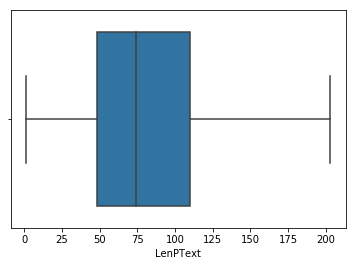

In [20]:
#How many words in the posts
sns.boxplot(postsdf['LenPText'], sym = '')

In [21]:
#How are the tags for our dataset compared to all the other tags?
tagscompdf = pd.read_csv('tags_min_50.csv', index_col = 0)
tagscompdf['TagName'] = tagscompdf['TagName'].astype(str)
#tagscompdf.set_index('TagName', inplace=True)
#tagspopdict = tagscompdf['Count'].to_dict()
tagscompdf.head()

,TagName,Count,ExcerptPostId,WikiPostId
Id,,,,
20225,qprocess,428,14678058.0,14678057.0
20226,ecma262,127,15073424.0,15073423.0
20227,contour,1237,14471240.0,14471239.0
20238,werkzeug,394,5167618.0,5167617.0
20239,httplib2,192,40217632.0,40217631.0


In [22]:
#What are the most popular tags
tagscompdf
tagsdf = pd.DataFrame(postsdf['PTags'].tolist()).stack().value_counts()
tagspopdict =tagsdf.to_dict()
tagscompdf['Dataset'] = tagscompdf['TagName'].apply(lambda x:tagspopdict.get(x, np.nan))
tagscompdf[['TagName', 'Dataset', 'Count']].sort_values('Dataset', ascending = False).head()

,TagName,Dataset,Count
Id,,,
3,javascript,5588.0,1542204
16,python,4533.0,881459
17,java,3523.0,1362522
1386,android,3350.0,1065239
5,php,2801.0,1159263


In [23]:
postsdf['PTags'].dtype

dtype('O')

In [24]:
df = tagscompdf[['TagName', 'Dataset', 'Count']]
df.set_index('TagName', inplace=True)
df.corr()

,Dataset,Count
Dataset,1.000000,0.936421
Count,0.936421,1.000000


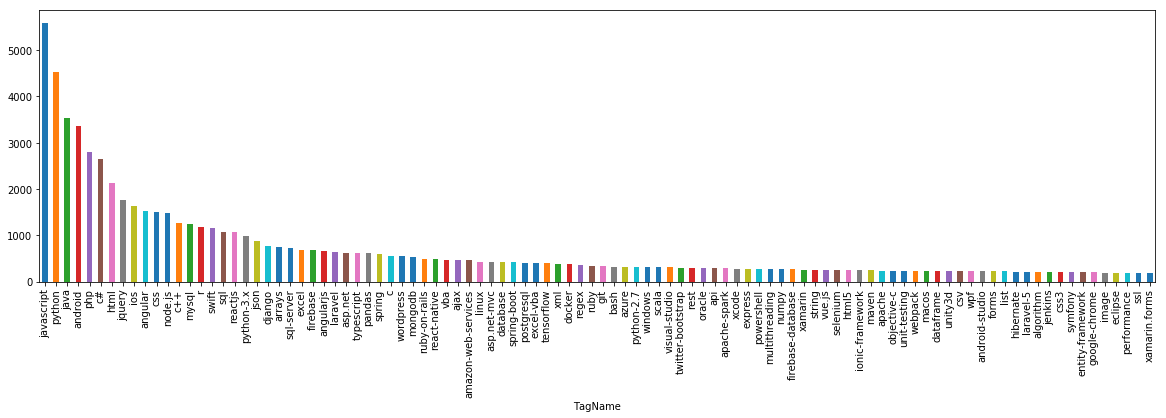

In [25]:
df = tagscompdf.copy()
df.set_index('TagName', inplace = True)
df = df.sort_values('Dataset', ascending=False)
df['Dataset'].head(100).plot(kind = 'bar', figsize = (20,5))
plt.show()
#df['Dataset'].head(30)

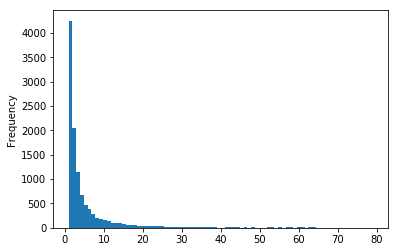

In [26]:
tagappliedmin = 80
df = tagscompdf[tagscompdf['Dataset'] <tagappliedmin]
df['Dataset'].plot(kind = 'hist', bins = tagappliedmin)
plt.show()

In [27]:
tagscompdf[tagscompdf['Dataset'] >=50].shape

(391, 5)

In [28]:
tagscompdf.shape

(22550, 5)

In [57]:
#Custom tokenizer
def customtokenizer(entry, negate = False, punctuation = True, stemming=True):
    
    #Breaks in sentences
    sentences = sent_tokenize(entry, language='english')
    
    #Breaks in words
    tokenizedsentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokenizedsentences.append(tokens)
    
    #Stem the sentences
    if stemming:
        stemmer = SnowballStemmer("english")
        stemmed = []
        for sentence in tokenizedsentences:
            sentencestemmed = [stemmer.stem(word.lower()) for word in sentence]
            stemmed.append(sentencestemmed)
    else:
        stemmed=tokenizedsentences
    
    
    #Applys the negation if needed
    if negate:
        sentiments = []
        for sentence in stemmed:
            tokens = mark_negation(sentence)
            sentiments.append(tokens)
    else:
        sentiments = stemmed
    
    #Cleans the Stop-words
    stopwords = set(nltk.corpus.stopwords.words('english'))
    stopwords.add('...')
    cleanedsw = []
    for sentence in sentiments:
        tokens = [word for word in sentence if (word not in stopwords) and ((word[:-4] not in stopwords) if word.endswith('_NEG') else True)]
        cleanedsw.append(tokens)
    
    #Clean the punctuation
    if punctuation:
        cleanedpunct = []
        for sentence in cleanedsw:
            tokens = [word for word in sentence if (word not in string.punctuation) and ((word[:-4] not in string.punctuation) if word.endswith('_NEG') else True)]
            cleanedpunct.append(tokens)
    else:
        cleanedpunct = cleanedsw
    
    #Clean the numbers
    cleanednumber = []
    for sentence in cleanedpunct:
        tokens = [word for word in sentence if not word.isdigit()]
        cleanednumber.append(tokens)
    
    
    #Sentences assembly
    assembly = []
    for sentence in cleanednumber:
        tokens = [word for word in sentence]
        assembly.extend(sentence)

    return ' '.join(assembly)
customtokenizer('''The movie, was not that, good. It was terribly bad. Hello, I'm 50% sure that but javascript or c++, javascript sucks! On the other hand python is so much better, I wish i was kiding :-). R is pretty good.''',
                stemming=True, negate = False, punctuation = True)

"movi good terribl bad hello 'm sure javascript c++ javascript suck hand python much better wish kide r pretti good"

In [31]:
#POST - Result for sample post - original version
postsdf['PText'].loc[sampleline]

' I have a .txt file called "1.txt" that I want to read in.  Since the file starts with 8 BOM characters, if I do the following: This will print nothing, because of something the BOM is doing. So, I decided to use the fin.ignore() function, in order to ignore the beginning BOM characters of the file.  However, still nothing is being printed.  Here is my complete program: I hypothesize that after the:  ifstream fin("1.txt");  line, it is already too late, since the BOM probably affected things with fin then.  So I need to somehow tell fin to ignore the BOM characters before it reads in the file, but I can\'t use fin.ignore() since I wouldn\'t have declared a fin object yet. Also, I know I can manually delete the BOM from my .txt file, but I\'m looking for a solution that only involves me writing a C++ program.  If I have thousands or millions of .txt files, deleting manually is not an option.  Also, I\'m not looking to download new software, like Notepad++ Here is all I have in the file

In [32]:
#POST - Result for sample post - TOKENIZED version
customtokenizer(postsdf['PText'].loc[sampleline])

".txt file call `` 1.txt '' want read sinc file start bom charact follow print noth becaus someth bom decid use fin.ignor function order ignor begin bom charact file howev still noth print complet program hypothes ifstream fin `` 1.txt '' line alreadi late sinc bom probabl affect thing fin need somehow tell fin ignor bom charact befor read file ca n't use_NEG fin.ignor_NEG sinc_NEG would_NEG n't_NEG declar_NEG fin_NEG object_NEG yet_NEG also know manual delet bom .txt file 'm look solut onli involv write c++ program thousand million .txt file delet manual option_NEG also 'm look_NEG download_NEG new_NEG softwar_NEG like_NEG notepad++_NEG file_NEG ``_NEG 1.txt_NEG ''_NEG ðïà¡±á hello site 's format doe n't let_NEG show_NEG actual_NEG file_NEG 15_NEG space_NEG bom_NEG hello_NEG"

In [33]:
#TITLE - Result for sample title - original version
postsdf['Title'].loc[sampleline]

'C++ - Am I using fin.ignore() incorrectly?'

In [34]:
#TITLE - Result for sample title - TOKENIZED version
customtokenizer(postsdf['Title'].loc[sampleline], negate = False)

'c++ use fin.ignor incorrect'

In [35]:
#Code tokenizer creation
text = """
class Foldermanagement():
def __init__(self):
    self.today = invoicemng.gettoday() + 7
       """
def codetokenizer(text):
    separators = string.punctuation + string.whitespace
    separators = [sep for sep in separators if sep != '_']
    separators_re = "|".join(re.escape(x) for x in separators)
    tokens = zip(re.split(separators_re, text), re.findall(separators_re, text))
    flattened = itertools.chain.from_iterable(tokens)
    cleaned = [x for x in flattened if x and not x.isspace()]
    
    #To gather the symbols by 2
    toreturn = []
    skip = False
    for index in range(len(cleaned)-1):
        if cleaned[index] in string.punctuation and cleaned[index+1] in string.punctuation and not skip:
            toreturn.append(cleaned[index]+cleaned[index+1])
            skip = True
        elif skip == True:
            skip = False
        else:
            toreturn.append(cleaned[index])
    
    #Digit cleaning
    toreturn = [word for word in toreturn if not word.isdigit()]
            
    return ' '.join(toreturn)
    
codetokenizer(text)

'class Foldermanagement () : def __init__ ( self ): self . today = invoicemng . gettoday () +'

In [36]:
#CODE - Result for sample code - original version

print(postsdf['PCode'].loc[sampleline])

ifstream fin("1.txt");

string temp = "";

char c = fin.get();

    while (!fin.eof())
    {
        if (c >= ' ' && c <= 'z')
        {
            temp += c;
        }

        c = fin.get();
    }

    cout << temp;
 #include <iostream>
#include <fstream>
#include <string>
#include <istream>

using namespace std;

int main()
{
ifstream fin("1.txt");

if (fin.fail())
{
    cout << "Fail\n";
}

else
{
    string temp = ""; // Will hold 1.txt's contents.

    fin.ignore(10, ' ');
    // Ignore first 10 chars of the file or stop at the first space char,
    // since the BOM at the beginning is causing problems for fin to read the file.
    // BOM is 8 chars, I wrote 10 to just be safe.

    char c = fin.get();

    while (!fin.eof())
    {
        if (c >= ' ' && c <= 'z') // checks if c stores a standard char.
        {
            temp += c;
        }

        c = fin.get();
    }

    cout << temp;

    // PROBLEM:  No text is printed to the screen from the above command.

    cout <

In [37]:
#CODE - Result for sample code - TOKENIZED version
' '.join(codetokenizer(postsdf['PCode'].loc[sampleline]))
codetokenizer(postsdf['PCode'].loc[sampleline])

'ifstream fin (" . txt ") ; string temp =" "; char c = fin . get () ; while (! fin . eof () ){ if ( c >= \'\' && c <= \' z \') { temp += c ;} c = fin . get () ;} cout << temp ;# include < iostream ># include < fstream ># include < string ># include < istream > using namespace std ; int main () { ifstream fin (" . txt ") ; if ( fin . fail () ){ cout << " Fail \\ n "; } else { string temp =" "; // Will hold . txt \' s contents . fin . ignore ( ,\' \') ;/ / Ignore first chars of the file or stop at the first space char ,/ / since the BOM at the beginning is causing problems for fin to read the file ./ / BOM is chars , I wrote to just be safe . char c = fin . get () ; while (! fin . eof () ){ if ( c >= \'\' && c <= \' z \') // checks if c stores a standard char .{ temp += c ;} c = fin . get () ;} cout << temp ;/ / PROBLEM : No text is printed to the screen from the above command . cout << temp . size () ;/ / prints }}'

In [38]:
#text tokenizin - dataframe update
postsdf['TText'] = postsdf['PText'].apply(customtokenizer,args=(False, True, True))
postsdf['TText_NEG'] = postsdf['PText'].apply(customtokenizer,args=(True, True, True))
postsdf['TCode'] = postsdf['PCode'].apply(codetokenizer)
postsdf['TTitle'] = postsdf['Title'].apply(customtokenizer,args=(False, True, True))
postsdf['TTitle_NEG'] = postsdf['Title'].apply(customtokenizer,args=(True, True, True))
postsdf[['TText', 'TText_NEG', 'PText', 'TCode', 'PCode', 'TTitle', 'TTitle_NEG', 'Title']].head(20)

,TText,TText_NEG,PText,TCode,PCode,TTitle,TTitle_NEG,Title
Id,,,,,,,,
48046688,hi tri instal python packag call pysptk ubuntu...,hi tri instal python packag call pysptk ubuntu...,Hi I was trying to install a python package c...,pip install pysptk / usr / bin / ld : cannot f...,pip install pysptk\n /usr/bin/ld: cannot find ...,tri instal pythonn packag encount `` find -lgc...,tri instal pythonn packag encount `` find_NEG ...,tried to install a pythonn package but encount...
48046690,tri make chrome extens display differ text pop...,tri make chrome extens display differ text pop...,I am trying to make a chrome extension that d...,"< script src ="" popup . js ""> </ script >< htm...","<script src=""popup.js""></script>\n<html>\n<hea...",updat chrome extens popup text,updat chrome extens popup text,Update chrome extension popup text
48046378,call dll python use ctype want pass ctype arra...,call dll python use ctype want pass ctype arra...,"Calling a dll from Python using ctypes, I wan...",ReturnVec = ctypes . c_float * len ( arrA ) t ...,ReturnVec = ctypes.c_float * len(arrA)\nt = ty...,python ctype pass ctype array dll,python ctype pass ctype array dll,Python ctypes: how to pass ctypes array to DLL?
48046379,django app user creat video collag use multipl...,django app user creat video collag use multipl...,I have a Django app with which users can crea...,client_max_body_size 100M fastcgi_buffers 16k ...,client_max_body_size 100M\n fastcgi_buffers 8 ...,nginx gunicorn bad gateway upstream prematur c...,nginx gunicorn bad gateway upstream prematur c...,nginx gunicorn 502 bad gateway: upstream prema...
48046382,'m tri implement hittest use arkit line inters...,'m tri implement hittest use arkit line inters...,I'm trying to implement hittest that is used ...,"std :: pair < bool , double > linePlaneInterse...","std::pair<bool, double> linePlaneIntersection...",implement hit test,implement hit test,Implementing hit test
48046691,tri integr valid text entri field reduc code s...,tri integr valid text entri field reduc code s...,I have been trying to integrate some validati...,import tkinter as tk # Create root window root...,import tkinter as tk\n\n\n# Create root window...,struggl understand tkinter entri valid code,struggl understand tkinter entri valid code,Struggling to understand this Tkinter entry va...
48046692,get follow error tri remov user ssas server ad...,get follow error tri remov user ssas server ad...,Getting following error when trying to remove...,,,analysi servic – error tri remov user server a...,analysi servic – error tri remov user server a...,Analysis Services – Errors when trying to remo...
48046694,wonder way cach arbitrari data web request ont...,wonder way cach arbitrari data web request ont...,I am wondering if there is a way to cache arb...,SharedPreferences,SharedPreferences SharedPreferences SharedPref...,android cach disk,android cach disk,Android Caching To Disk
48046383,respons look like `` id '' `` name '' `` test ...,respons look like `` id '' `` name '' `` test ...,"My response looks like this: [\n {\n ""id""...",,,valid respons valu contain number sign,valid respons valu contain number sign,How to validate response value containing the ...


In [39]:
mask = postsdf['TText'] != ''
postsdf = postsdf[mask]
#postsdf.isnull().sum()

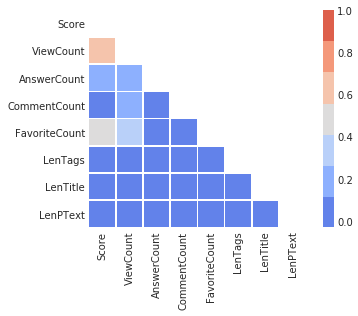

In [80]:

df = postsdf[['Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'LenTags', 'LenTitle', 'LenPText']]
df['FavoriteCount'] = df['FavoriteCount'].fillna(0)

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, cmap=sns.color_palette("coolwarm", 7), linewidths=.5)


In [82]:

postsdf[['Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'LenTags', 'LenTitle', 'LenPText']].describe()


,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,LenTags,LenTitle,LenPText
count,49415.000000,49415.000000,49415.000000,49415.000000,49415.000000,49415.000000,49415.000000,49415.000000
mean,0.441526,33.135384,0.890499,2.008459,0.099484,3.015076,8.884569,90.837843
std,1.135770,62.651187,0.931156,2.782937,0.376026,1.214047,3.606835,110.137788
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,2.000000,6.000000,49.000000
50%,0.000000,28.000000,1.000000,1.000000,0.000000,3.000000,8.000000,74.000000
75%,1.000000,39.000000,1.000000,3.000000,0.000000,4.000000,11.000000,111.000000
max,78.000000,8543.000000,18.000000,41.000000,16.000000,5.000000,32.000000,11147.000000


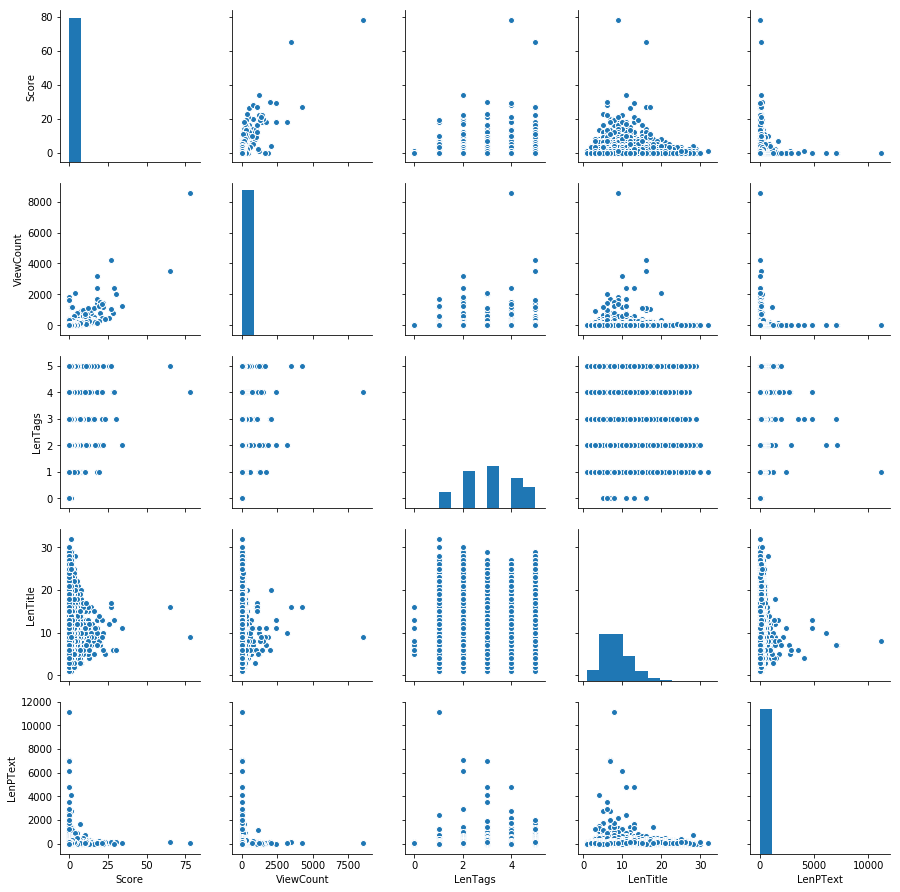

In [81]:
df = postsdf[['Score', 'ViewCount', 'LenTags', 'LenTitle', 'LenPText']]
sns.pairplot(df)


In [85]:
#Drop all the line with no tags
postsdf = postsdf[postsdf['LenTags'] != 0]
postsdf.shape

(49399, 34)

In [86]:
#Tokenized text saving
postsdf[['TText', 'TText_NEG', 'PText', 'TCode', 'PCode', 'TTitle', 'TTitle_NEG', 'Title', 'PTags', 'Tags']].to_csv('Cleaned_Posts.csv')
#postsdf.columns.values

In [41]:
saveddf = pd.read_csv('Cleaned_Posts.csv', index_col='Id')
saveddf.shape

(49415, 10)

In [42]:
saveddf.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10056
PCode          9629
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [43]:
#Text vectorizer feature
def cvect(corpus, max_df = 0.8, max_features=None, ngram_range = (1,1), min_df = 3):
    cvec = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, ngram_range = ngram_range, vocabulary=None, tokenizer=None)
    term_freq = cvec.fit_transform(corpus)
    zipped = zip([k for k in sorted(cvec.vocabulary_, key=cvec.vocabulary_.get, reverse=False)], np.asarray(term_freq.sum(axis=0))[0])
    vocabulary = {x[0] : x[1] for x in zipped}
    vocabulary_index = cvec.vocabulary_
    return term_freq, vocabulary, vocabulary_index

In [44]:
#Text analysis
Posts_freq, Post_vocabulary, vocabulary_index = cvect(saveddf['TText'], max_df = 1., min_df = 5, max_features=None, ngram_range = (1,1))
len(Post_vocabulary)

9929

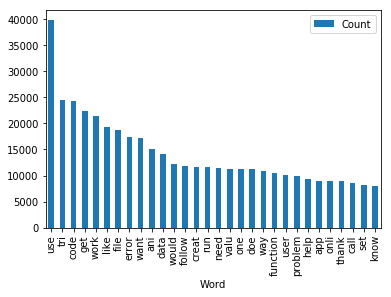

In [45]:
#What is the total vocabulary for text?
df = pd.DataFrame(list(Post_vocabulary.items()))
df.columns = ['Word', 'Count']
df.set_index('Word', inplace=True)
df = df.sort_values('Count', ascending=False)
df.head(30).plot(kind = 'bar')
plt.show()

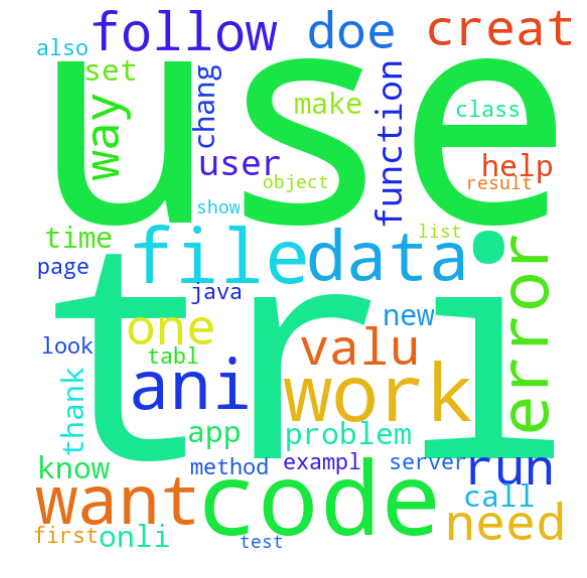

In [46]:
sample = df[:50]
mimword = sample.min()/500
chain = ''
for index, line in sample.iterrows():
    iterations = line['Count'] // mimword
    spacedword = index + ' '
    wordreplicated = str(spacedword) * int(iterations)
    chain += wordreplicated

# Create the wordcloud object
wordcloud = WordCloud(width=540, height=540, margin=0, max_words=100, background_color="White").generate(chain)
 
# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)
plt.show()

In [47]:
#Title analysis
Title_freq, Title_vocabulary, vocabulary_index = cvect(saveddf['TTitle'], max_df = 1., min_df = 5, max_features=None, ngram_range = (1,1))
len(Title_vocabulary)

4108

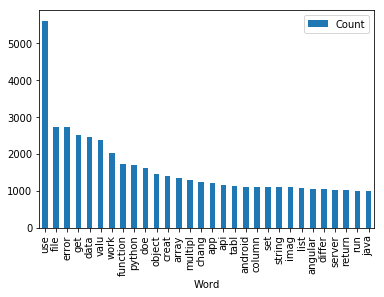

In [48]:
#What is the total vocabulary for text?
df = pd.DataFrame(list(Title_vocabulary.items()))
df.columns = ['Word', 'Count']
df.set_index('Word', inplace=True)
df = df.sort_values('Count', ascending=False)
df.head(30).plot(kind = 'bar')
plt.show()

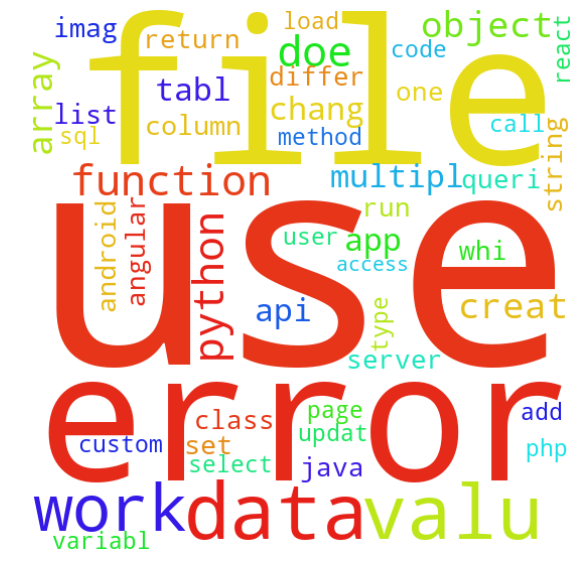

In [49]:
sample = df[:50]
mimword = sample.min()/500
chain = ''
for index, line in sample.iterrows():
    iterations = line['Count'] // mimword
    spacedword = index + ' '
    wordreplicated = str(spacedword) * int(iterations)
    chain += wordreplicated

# Create the wordcloud object
wordcloud = WordCloud(width=540, height=540, margin=0, max_words=100, background_color="White").generate(chain)
 
# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.margins(x=0, y=0)
plt.show()